In [77]:
import pandas as pd
import numpy as np
from scipy import stats
from IPython.display import display, Math
import os
data_dir = './data'

In [78]:
data = pd.read_excel(os.path.join(data_dir, 'fox_rabbit.xls'),header=0)
data

,fox,rabbit
0,13.997,5.987
1,13.994,6.008
2,14.013,6.024
3,13.997,6.003
4,14.011,5.992
...,...,...
995,13.986,6.021
996,14.008,6.004
997,13.996,5.996
998,14.014,5.995


In [79]:
R_data = data.rabbit.values
F_data = data.fox.values

In [ ]:
def prepare_var_data(R, F, p):
    """
    Формирование матриц X и Y для VAR(p).
    R, F: одномерные numpy-массивы с временными рядами (длина T).
    p: порядок лага.
    
    Возвращает:
    X: матрицу (T - p) x (2p + 1)
    Y: матрицу (T - p) x 2
    """
    T = len(R)
    # Инициализируем X и Y
    # Количество строк (наблюдений) будет T - p
    # Количество столбцов в X: (2p + 1) (R_lags + F_lags + константа)
    X = []
    Y = []
    
    for t in range(p, T):
        # Формируем строку X_t
        row = []
        # Добавляем лаги R
        for lag in range(1, p+1):
            row.append(R[t - lag])
        # Добавляем лаги F
        for lag in range(1, p+1):
            row.append(F[t - lag])
        # Добавляем константу
        row.append(1.0)
        
        X.append(row)
        
        # Формируем соответствующий Y_t = (R_t, F_t)
        Y.append([R[t], F[t]])
    
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

def fit_var_ols(X, Y):
    """
    Оценивает матрицу коэффициентов A для системы Y = X A
    где Y размером (N x 2), X размером (N x K), A будет размером (K x 2).
    Возвращает A, остатки, оценку ковариационной матрицы остатков.
    """
    # A_hat = (X^T X)^(-1) X^T Y
    # X^T X: размер (K x K)
    # X^T Y: размер (K x 2)
    
    # Предварительная проверка на обратимость (X^T X)
    XtX = X.T @ X
    XtY = X.T @ Y
    inv_XtX = np.linalg.inv(XtX)
    A_hat = inv_XtX @ XtY  # размер (K, 2)
    
    # Остатки E = Y - X A_hat
    E = Y - X @ A_hat  # (N x 2)
    
    # Оценка ковариационной матрицы остатков
    N = X.shape[0]  # число наблюдений
    Sigma_hat = (E.T @ E) / N  # (2 x 2)
    
    return A_hat, E, Sigma_hat, inv_XtX

def compute_bic(Sigma_hat, p, T_eff, num_params):
    """
    Вычисляет BIC для данной модели.
    
    Sigma_hat: оценка ковариации остатков (2 x 2)
    p: лаг
    T_eff: эффективное число наблюдений (T - p)
    num_params: количество оцениваемых параметров (k).
    """
    # BIC = (T_eff) * ln(det(Sigma_hat)) + num_params * ln(T_eff)
    det_Sigma = np.linalg.det(Sigma_hat)
    bic_val = T_eff * np.log(det_Sigma) + num_params * np.log(T_eff)
    return bic_val

def var_select_order(R, F, p_max):
    """
    Перебирает от p=1 до p_max, ищет минимальный BIC.
    Возвращает (p_opt, список (p, BIC(p)) для анализа).
    """
    T = len(R)
    results = []
    for p in range(1, p_max+1):
        # Сформируем X и Y
        X, Y = prepare_var_data(R, F, p)
        T_eff = X.shape[0]  # T - p
        
        # Оценим модель
        A_hat, E, Sigma_hat, inv_XtX = fit_var_ols(X, Y)
        
        # Число параметров в модели (k = 2*(2p+1))
        num_params = 2*(2*p + 1)
        
        # Считаем BIC
        bic_val = compute_bic(Sigma_hat, p, T_eff, num_params)
        
        results.append((p, bic_val))
    
    # Выбираем p с минимальным BIC
    results.sort(key=lambda x: x[1])  # сортируем по BIC
    p_opt = results[0][0]
    
    return p_opt, results

# 1) Зададим p_max
p_max = 10  # допустим, хотим перебрать лаги от 1 до 5

# 2) Найдём оптимальный лаг по BIC
p_opt, all_results = var_select_order(R_data, F_data, p_max)
print("Список (p, BIC):")
for r in all_results:
    print(f"p={r[0]}, BIC={r[1]:.4f}")
print(f"Оптимальный p по BIC: {p_opt}")

Список (p, BIC):
p=1, BIC=-18299.7924
p=2, BIC=-18263.3151
p=3, BIC=-18223.4383
p=4, BIC=-18182.2045
p=5, BIC=-18138.2157
p=6, BIC=-18094.6158
p=7, BIC=-18052.3001
p=8, BIC=-18015.4166
p=9, BIC=-17971.2578
p=10, BIC=-17925.3673
Оптимальный p по BIC: 1


In [81]:
# 3) Оценим модель с p_opt
X_opt, Y_opt = prepare_var_data(R_data, F_data, p_opt)
A_hat, E, Sigma_hat, inv_XtX = fit_var_ols(X_opt, Y_opt)
N_eff = X_opt.shape[0]

print("\nОценённая матрица коэффициентов (A_hat):")
print(A_hat)
print("\nКовариационная матрица остатков (Sigma_hat):")
print(Sigma_hat)

p = p_opt  # оптимальный порядок лага, найденный ранее

# Извлекаем коэффициенты для двух уравнений:
# Для уравнения R_t:
coeffs_R = A_hat[:, 0]  # коэффициенты (первые p_opt для лагов R, далее p_opt для лагов F, затем константа)
# Для уравнения F_t:
coeffs_F = A_hat[:, 1]

# Формирование строки LaTeX для уравнения R_t
eq_R = "R_t = "
# Коэффициенты при лаговых значениях R:
for i in range(p):
    eq_R += f"({coeffs_R[i]:.4f})\\,R_{{t-{i+1}}} + "
# Коэффициенты при лаговых значениях F:
for i in range(p):
    eq_R += f"({coeffs_R[p+i]:.4f})\\,F_{{t-{i+1}}} + "
# Константа:
eq_R += f"({coeffs_R[-1]:.4f})"

# Формирование строки LaTeX для уравнения F_t
eq_F = "F_t = "
# Коэффициенты при лаговых значениях R:
for i in range(p):
    eq_F += f"({coeffs_F[i]:.4f})\\,R_{{t-{i+1}}} + "
# Коэффициенты при лаговых значениях F:
for i in range(p):
    eq_F += f"({coeffs_F[p+i]:.4f})\\,F_{{t-{i+1}}} + "
# Константа:
eq_F += f"({coeffs_F[-1]:.4f})"

# Вывод уравнений с использованием display(Math(...)):
display(Math(eq_R))
display(Math(eq_F))


Оценённая матрица коэффициентов (A_hat):
[[ 0.49384248  0.47292049]
 [-0.51272292  0.51915366]
 [10.2147755   3.8944143 ]]

Ковариационная матрица остатков (Sigma_hat):
[[ 1.04997433e-04 -3.12167575e-07]
 [-3.12167575e-07  1.01240800e-04]]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [82]:
# 4) Проверка значимости коэффициентов
#    Для каждого из 2 уравнений:
#      A_hat имеет размер (K=2p+1) x 2.
#    Стандартные ошибки считаются на основе дисперсии остатков и inv(X^T X).

# Размер A_hat: (K, 2). 
# Ковариация для оценок коэффициентов (Var(A_hat)) = sigma^2 * inv(X^T X) — 
# но здесь у нас двумерная уравнение, поэтому нужно аккуратно извлечь 
# стандартные ошибки для каждого столбца по аналогии с MLR (см. ниже).

K = X_opt.shape[1]  # = 2*p_opt + 1
# Sigma_hat — это 2х2. Для уравнения R_t дисперсия остатков = Sigma_hat[0,0]
# Для уравнения F_t дисперсия остатков = Sigma_hat[1,1]

varA_R = Sigma_hat[0, 0] * inv_XtX  # ковариационная матрица для коэффициентов в первом уравнении
varA_F = Sigma_hat[1, 1] * inv_XtX  # для второго уравнения

seA_R = np.sqrt(np.diag(varA_R))  # стандартные ошибки (K,) для уравнения R
seA_F = np.sqrt(np.diag(varA_F))  # (K,) для уравнения F

# Соберём t-статистики (или z-статистики, если N велико) для каждого коэффициента
# уравнение R_t:
t_vals_R = A_hat[:, 0] / seA_R
# уравнение F_t:
t_vals_F = A_hat[:, 1] / seA_F

print("\nКоэффициенты уравнения R_t:")
for i in range(K):
    print(f"A_R[{i}] = {A_hat[i,0]:.4f}, SE={seA_R[i]:.4f}, t={t_vals_R[i]:.4f}")
print("\nКоэффициенты уравнения F_t:")
for i in range(K):
    print(f"A_F[{i}] = {A_hat[i,1]:.4f}, SE={seA_F[i]:.4f}, t={t_vals_F[i]:.4f}")

# При больших N для проверки значимости можно смотреть, 
# превышает ли |t| критическое значение (например, ~2.58 на уровне 1% при больших степенях свободы).
# Либо смотреть p-value, но тогда потребуется использовать функции распределения Стьюдента.


Коэффициенты уравнения R_t:
A_R[0] = 0.4938, SE=0.0223, t=22.1506
A_R[1] = -0.5127, SE=0.0229, t=-22.3879
A_R[2] = 10.2148, SE=0.3500, t=29.1872

Коэффициенты уравнения F_t:
A_F[0] = 0.4729, SE=0.0219, t=21.6022
A_F[1] = 0.5192, SE=0.0225, t=23.0855
A_F[2] = 3.8944, SE=0.3437, t=11.3323


In [83]:
# 5) Доверительные интервалы
#    На уровне значимости 1% (двухсторонний интервал) z-квантиль ~ 2.575829 (или t-квантиль)
alpha = 0.01  # уровень значимости для 99% доверительного интервала
z_99 = stats.norm.ppf(1 - alpha/2)

CI_R = []
CI_F = []
for i in range(K):
    # для коэффициентов уравнения R_t
    ci_low = A_hat[i, 0] - z_99*seA_R[i]
    ci_high = A_hat[i, 0] + z_99*seA_R[i]
    CI_R.append((ci_low, ci_high))
    
    # для уравнения F_t
    ci_low = A_hat[i, 1] - z_99*seA_F[i]
    ci_high = A_hat[i, 1] + z_99*seA_F[i]
    CI_F.append((ci_low, ci_high))

print("\nДоверительные интервалы 99% для уравнения R_t:")
for i, (low, high) in enumerate(CI_R):
    print(f"  Коэффициент {i}: [{low:.4f}, {high:.4f}]")

print("\nДоверительные интервалы 99% для уравнения F_t:")
for i, (low, high) in enumerate(CI_F):
    print(f"  Коэффициент {i}: [{low:.4f}, {high:.4f}]")



Доверительные интервалы 99% для уравнения R_t:
  Коэффициент 0: [0.4364, 0.5513]
  Коэффициент 1: [-0.5717, -0.4537]
  Коэффициент 2: [9.3133, 11.1162]

Доверительные интервалы 99% для уравнения F_t:
  Коэффициент 0: [0.4165, 0.5293]
  Коэффициент 1: [0.4612, 0.5771]
  Коэффициент 2: [3.0092, 4.7796]


In [84]:
# 6) Прогноз на 1, 2, 3 шага вперёд
#    Для прогноза на h шагов вперёд: 
#       R_{T+h} = f(R_{T}, R_{T-1}, ..., F_{T}, F_{T-1}, ...)
#    в зависимости от p. Делаем итеративно.

def var_forecast(R, F, A_hat, p, h):
    """
    Построим прогноз на h шагов вперёд из конца выборки.
    R, F - исходные ряды (длина T).
    A_hat - оценённая матрица коэффициентов (размер (2p+1, 2)).
    p - порядок лага.
    h - сколько шагов вперёд прогнозируем.

    Возвращаем списки: R_forecast, F_forecast (каждого длины h).
    """
    R_pred = list(R)  # скопируем текущие ряды, чтобы дополнять
    F_pred = list(F)
    T_full = len(R_pred)

    for step in range(h):
        # Будем прогнозировать R_{T_full} и F_{T_full} (новую точку)
        # Понадобятся p предыдущих значений.
        X_new = []
        # Лаги R
        for lag in range(1, p+1):
            X_new.append(R_pred[T_full - lag])
        # Лаги F
        for lag in range(1, p+1):
            X_new.append(F_pred[T_full - lag])
        # Константа
        X_new.append(1.0)
        X_new = np.array(X_new)

        # Прогноз (R_hat, F_hat) = X_new @ A_hat
        # A_hat: (2p+1, 2)
        new_est = X_new @ A_hat  # получим (2,) -> [R_hat, F_hat]

        R_pred.append(new_est[0])
        F_pred.append(new_est[1])
        T_full += 1

    # Берём последние h прогнозных значений
    R_forecast = R_pred[-h:]
    F_forecast = F_pred[-h:]
    return R_forecast, F_forecast

h_steps = 3
R_fcst, F_fcst = var_forecast(R_data, F_data, A_hat, p_opt, h_steps)
print(f"\nПрогноз на {h_steps} шага вперёд:")
for i in range(h_steps):
    print(f"Шаг +{i+1}: R={R_fcst[i]:.2f}, F={F_fcst[i]:.2f}")



Прогноз на 3 шага вперёд:
Шаг +1: R=6.00, F=14.00
Шаг +2: R=6.00, F=14.00
Шаг +3: R=6.00, F=14.00


In [85]:
A11 = np.sum(A_hat[:p, 0])        # суммарный коэффициент при R_t-1 ... R_t-p для кроликов
A12 = np.sum(A_hat[p:2*p, 0])      # суммарный коэффициент при F_t-1 ... F_t-p для кроликов
c_R  = A_hat[-1, 0]               # константа для R_t

# Для уравнения F_t:
A21 = np.sum(A_hat[:p, 1])         # суммарный коэффициент при R_t-1 ... R_t-p для лис
A22 = np.sum(A_hat[p:2*p, 1])       # суммарный коэффициент при F_t-1 ... F_t-p для лис
c_F  = A_hat[-1, 1]               # константа для F_t

# Система для равновесия:
# (1 - A11)*R* - A12*F* = c_R
# -A21*R* + (1 - A22)*F* = c_F
B = np.array([[1 - A11, -A12],
              [-A21,    1 - A22]])
C_vec = np.array([c_R, c_F])
steady_state = np.linalg.solve(B, C_vec)
R_star, F_star = steady_state

print("\nРавновесные уровни (стационарное состояние):")
print("R* =", R_star)
print("F* =", F_star)


Равновесные уровни (стационарное состояние):
R* = 5.999619171123132
F* = 13.999809390080506



Проверка равновесия (A_var * steady_state + C_const): [ 5.99961917 13.99980939]


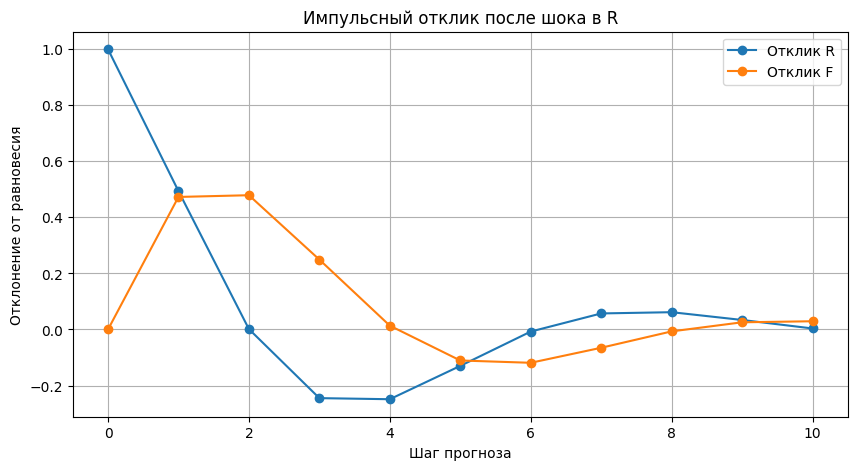

In [86]:
import matplotlib.pyplot as plt
# Импульсный отклик:
# Для демонстрации построим IRF — посмотрим, как система реагирует на шок в R_t.
# Для VAR(1) IRF удобно рассчитывать итеративно:
# Если p>1, можно использовать компаньонную форму, но здесь для упрощения аппроксимируем VAR(p)
# через агрегированные коэффициенты, то есть определим матрицу:
A_var = np.array([[A11, A12],
                  [A21, A22]])
C_const = np.array([c_R, c_F])  # константный вектор

# Проверим, что равновесие удовлетворяет: Y* = A_var Y* + C_const
print("\nПроверка равновесия (A_var * steady_state + C_const):", A_var @ steady_state + C_const)

# Симуляция IRF:
H = 10  # горизонт прогноза (шаги)
Y0 = steady_state  # начальное равновесие
Y0_impulse = Y0.copy()
Y0_impulse[0] += 1.0  # добавляем единичный шок в R_t

irf = np.zeros((H+1, 2))
irf[0, :] = Y0_impulse
for h in range(1, H+1):
    irf[h, :] = A_var @ irf[h-1, :] + C_const

# Для удобства смотрим отклонения от равновесия:
irf_dev = irf - steady_state

plt.figure(figsize=(10,5))
plt.plot(irf_dev[:,0], marker='o', label="Отклик R")
plt.plot(irf_dev[:,1], marker='o', label="Отклик F")
plt.xlabel("Шаг прогноза")
plt.ylabel("Отклонение от равновесия")
plt.title("Импульсный отклик после шока в R")
plt.legend()
plt.grid(True)
plt.show()

In [87]:
# =============================================================================
# (е) Тест Грейнджера на причинно-следственные связи
# =============================================================================
# Проверим, помогает ли включение лагов R улучшить прогноз для F.
# Для этого сравним полную модель (с лагами R и F) с урезанной моделью (только лаги F).

# Используем ту же матрицу X и зависимую переменную Y, полученные ранее.
# Для полной модели (уравнение для F):
Y_F = Y_opt[:, 1]  # зависимая переменная F_t
n_obs = X_opt.shape[0]  # число наблюдений

# Оценка полной модели уже была проведена: A_hat (2 столбца) – для F у нас:
# Для F: коэффициенты = A_hat[:, 1]
rss_full = np.sum((Y_F - X_opt @ A_hat[:, 1])**2)

# Для урезанной модели исключим столбцы, отвечающие за лаги R.
# Структура X: [Rlags (0...p-1), Flags (p...2*p-1), constant (2*p)]
X_restricted = X_opt[:, p:(2*p+1)]  # оставляем лаги F и константу
k_restricted = X_restricted.shape[1]

# Оценка урезанной модели:
beta_restricted = np.linalg.inv(X_restricted.T @ X_restricted) @ X_restricted.T @ Y_F
E_restricted = Y_F - X_restricted @ beta_restricted
rss_restricted = np.sum(E_restricted**2)

# Число ограничений = p (исключаем p коэффициентов для лагов R)
num_restr = p
k_full = 2*p + 1  # число параметров в полной модели

# Расчёт F-статистики:
F_stat = ((rss_restricted - rss_full) / num_restr) / (rss_full / (n_obs - k_full))
p_value = 1 - stats.f.cdf(F_stat, num_restr, n_obs - k_full)

print("\nТест Грейнджера для проверки гипотезы 'R грейнджер-причиняет F':")
print("F-статистика =", F_stat)
print("p-value =", p_value)
if p_value < 0.05:
    print("Гипотеза отклоняется: лаги R статистически значимо улучшают прогноз F.")
else:
    print("Гипотезу отклонить не удалось: нет статистически значимого влияния лагов R на F.")


Тест Грейнджера для проверки гипотезы 'R грейнджер-причиняет F':
F-статистика = 465.25248118919205
p-value = 1.1102230246251565e-16
Гипотеза отклоняется: лаги R статистически значимо улучшают прогноз F.
